In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

2025-04-19 08:21:23.292956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745050883.307570   30518 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745050883.312268   30518 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745050883.324805   30518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745050883.324816   30518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745050883.324818   30518 computation_placer.cc:177] computation placer alr

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Sat Apr 19 08:21:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:C1:00.0 Off |                  Off |
| 33%   41C    P8             30W /  450W |      18MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Dataset Generation

## Dataset Ingestion

In [4]:
# parameters
batch_size = 256
img_height = 224
img_width = 224
data_dir = "/workspace/data_224_flited_20"
NUM_CLASSES = 24
EPOCHS = 100

In [5]:
def generate_dataset(_data_dir: str) -> dict[tf.data.Dataset]:
    # load training dataset
    train_ds = keras.utils.image_dataset_from_directory(
        directory=f"{data_dir}/train",
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=777
    )
    
    # load test dataset
    test_ds = keras.utils.image_dataset_from_directory(
        directory=f"{data_dir}/test",
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=False
    )
    
    # normalize pixel values to [0,1]
    normalization_layer = keras.layers.Rescaling(scale=1./255) # rescale to [0, 1] 
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
    return {
        'train': train_ds,
        'test': test_ds
    }

In [6]:
ds = generate_dataset(data_dir)
ds

Found 4150 files belonging to 24 classes.


I0000 00:00:1745050886.016172   30518 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Found 1026 files belonging to 24 classes.


{'train': <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'test': <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>}

In [7]:
import matplotlib.pyplot as plt
import os

def visualize_ds(_ds, _data_dir) -> None:
    train_dir = f"{_data_dir}/train"
    class_names = sorted(
        d for d in os.listdir(train_dir)
        if os.path.isdir(os.path.join(train_dir, d))
    )
    
    # Take one batch
    images, labels = next(iter(_ds['train']))
    
    # Plot the first 9 images
    plt.figure(figsize=(8, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

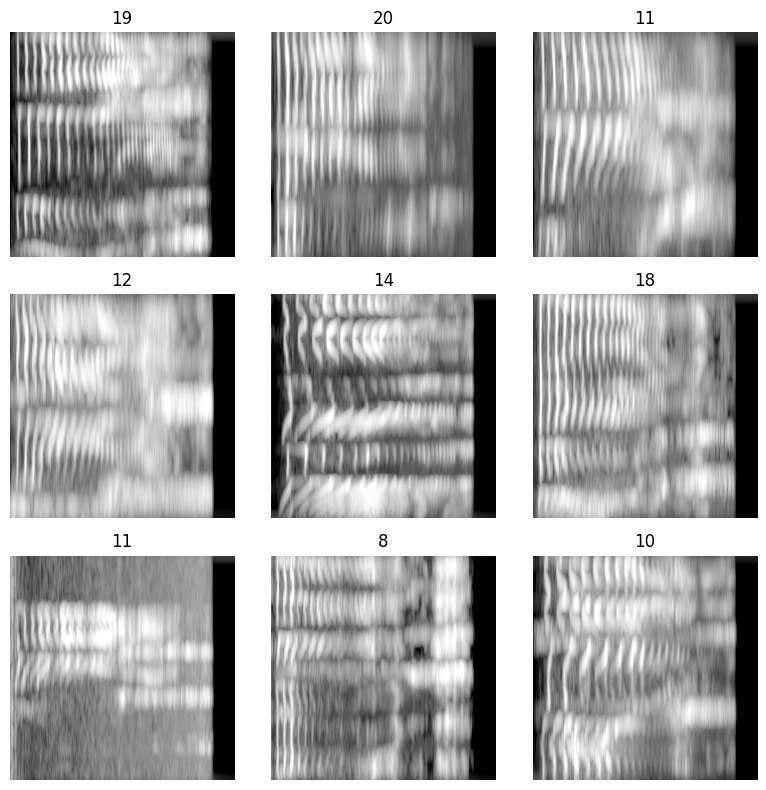

In [8]:
visualize_ds(ds, data_dir)

## Dataset Augmentation

In [9]:
data_augmentation = keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.1),
        keras.layers.RandomContrast(0.1),
    ])
def _aug_data(image, label):
    image = data_augmentation(image, training=True)
    return image, label

def augment_data(_ds: dict[tf.data.Dataset]) -> dict[tf.data.Dataset]:
    _ds['train'] = _ds['train'].map(_aug_data, num_parallel_calls=tf.data.AUTOTUNE)
    return _ds

In [10]:
aug_ds = augment_data(ds)
aug_ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'test': <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>}

2025-04-19 08:21:31.570504: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node sequential_1/random_contrast_1/Add/_18}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-04-19 08:21:31.570531: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node sequential_1/random_contrast_1/Add/_18}}]]
	 [[sequential_1/random_contrast_1/Add/_17]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-04-19 08:21:31.570564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1746591308523269476


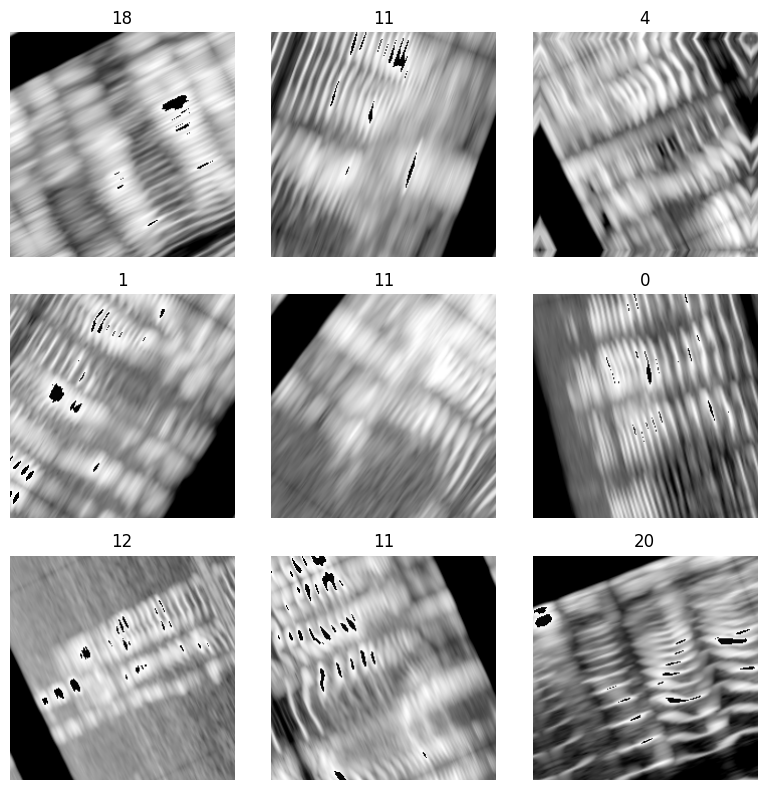

In [11]:
visualize_ds(aug_ds, data_dir)

## Model Building

### Clear Cache

In [12]:
import gc
import shutil
import os

def clear_tf_cache(cache_dir: str = None):
    # 1) Clear any existing Keras/TensorFlow graphs & sessions
    keras.backend.clear_session()
    try:
        tf.compat.v1.reset_default_graph()
    except AttributeError:
        pass  # only in TF‑v1 graph mode

    # 2) Run Python garbage collector
    gc.collect()

    # 3) delete the on‑disk cache if cache_dir specified
    if cache_dir and os.path.exists(cache_dir):
        if os.path.isfile(cache_dir):
            os.remove(cache_dir)
        else:
            shutil.rmtree(cache_dir)

    # 4) Reset GPU memory stats (does not free memory, but resets counters)
    for gpu in tf.config.list_physical_devices('GPU'):
        try:
            tf.config.experimental.reset_memory_stats(gpu.name)
        except:
            pass


### EfficientNetV2

In [13]:
def build_model(img_height: int, img_width: int, num_classes: int) -> keras.Model:
    inputs = keras.Input(shape=(img_height, img_width, 3))

    clear_tf_cache()
    
    # EfficientNetV2 backbone
    backbone = keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_tensor=inputs)
    #backbone.trainable = False  # Freeze backbone initially

    # Classification head
    x = keras.layers.GlobalAveragePooling2D()(backbone.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Training and Eval functions

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pickle
def train_model(
    model: keras.Model,
    train_ds: tf.data.Dataset,
    val_ds: tf.data.Dataset,
    model_path,
    epochs: int = 10,
) -> keras.callbacks.History:
    """
    Fits the model on train_ds, validating on val_ds.
    Returns the training History.
    """
    if not os.path.isdir(model_path):
        os.makedirs(model_path)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[reduce_lr, early_stopping]
    )

    # Save training history
    with open(f"{model_path}/history.json", 'wb') as file:
        pickle.dump(history.history, file)
    
    # Save the trained model in Keras format
    model.save(f"{model_path}/model.keras")
    return history

In [15]:
def evaluate_model(
    model: keras.Model,
    test_ds: tf.data.Dataset
) -> tuple[float, float]:
    """
    Evaluates the model on test_ds.
    Prints and returns (loss, accuracy).
    """
    loss, acc = model.evaluate(test_ds)
    print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")
    return loss, acc

# Model Training

## EfficientNetV2

### Training without Augmentation

In [170]:
# Train the model
model = build_model(img_height, img_width, NUM_CLASSES)
history = train_model(model, ds['train'], ds['test'], '/workspace/models/noaug_model', epochs=EPOCHS)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.0512 - loss: 4.2435 - val_accuracy: 0.0419 - val_loss: 3.2223 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.1159 - loss: 3.4931 - val_accuracy: 0.0439 - val_loss: 3.2034 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.2109 - loss: 2.7652 - val_accuracy: 0.0439 - val_loss: 3.2225 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.4036 - loss: 2.0052 - val_accuracy: 0.0439 - val_loss: 3.2208 - learning_rate: 0.0010
Epoch 5/100
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5396 - loss: 1.4557
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5425 - loss: 1.4454 - val_accuracy: 0.0575 - val_loss: 3.2561 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.6259 - loss: 1.1088

(0.4941301643848419, 0.8664717078208923)

In [174]:
# Evaluate on test set
evaluate_model(model, ds['test'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8492 - loss: 0.4992 
Test loss: 0.4941, Test accuracy: 0.8665


(0.4941301643848419, 0.8664717078208923)

### Training with Augmentation

In [172]:
# Train the model on augmented_ds
aug_model = build_model(img_height, img_width, NUM_CLASSES)
aug_history = train_model(aug_model, aug_ds['train'], aug_ds['test'], '/workspace/models/aug_model', epochs=EPOCHS)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0537 - loss: 4.2846 - val_accuracy: 0.0429 - val_loss: 3.1978 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.0942 - loss: 3.5266 - val_accuracy: 0.0439 - val_loss: 3.2018 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.1532 - loss: 3.0681 - val_accuracy: 0.0546 - val_loss: 3.2054 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.2696 - loss: 2.4939 - val_accuracy: 0.0595 - val_loss: 3.1721 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.4147 - loss: 1.9028 - val_accuracy: 0.0468 - val_loss: 3.2008 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.5385 - loss: 1.4710 - val_accuracy: 0.0624 - val_loss: 3.1874 - learning_rate: 0.0010
Epoch 7/100
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6375 - loss: 1.15

(0.4941301643848419, 0.8664717078208923)

In [173]:
# Evaluate on test set
evaluate_model(aug_model, aug_ds['test'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8869 - loss: 0.3937 
Test loss: 0.3696, Test accuracy: 0.9025


(0.3696119487285614, 0.9025341272354126)

## EfficientNetV2 with CBAM

### No Augmentation

In [16]:
def cbam_module(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    shared_layer_one = keras.layers.Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal')
    shared_layer_two = keras.layers.Dense(channel, kernel_initializer='he_normal')

    avg_pool = keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = keras.layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = keras.layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    channel_attention = keras.layers.Add()([avg_pool, max_pool])
    channel_attention = keras.layers.Activation('sigmoid')(channel_attention)

    channel_refined = keras.layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = keras.layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    refined_feature = keras.layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


def build_efficientnet_cbam(img_height: int, img_width: int, num_classes: int) -> keras.Model:
    # --- Build model with CBAM at the tail ---
    base = keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(img_height,img_width,3))
    x = base.output
    
    # Insert CBAM after the final MBConv stage
    x = cbam_module(x, reduction_ratio=8)
    
    # Classification head
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1000, activation="softmax")(x)
    
    model = keras.models.Model(inputs=base.input, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [27]:
# Train the model
model_cbam = build_efficientnet_cbam(img_height, img_width, NUM_CLASSES)
history_cbam = train_model(model_cbam, ds['train'], ds['test'], '/workspace/models/efficientdetv2_cbam/noaug_model', epochs=EPOCHS)

Epoch 1/100


2025-04-19 09:42:04.484751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_47', 124 bytes spill stores, 116 bytes spill loads



16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0309 - loss: 6.2074     

2025-04-19 09:42:31.060623: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_24', 124 bytes spill stores, 116 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.0328 - loss: 6.0940 - val_accuracy: 0.0429 - val_loss: 6.4578 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.1411 - loss: 2.8682 - val_accuracy: 0.0429 - val_loss: 5.2527 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.3634 - loss: 2.0056 - val_accuracy: 0.0000e+00 - val_loss: 8.8178 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5757 - loss: 1.2645 - val_accuracy: 0.0000e+00 - val_loss: 9.1331 - learning_rate: 0.0010
Epoch 5/100
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7069 - loss: 0.8994
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7093 - loss: 0.8910 - val_accuracy: 0.0000e+00 - val_loss: 7.4638 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7942 - loss: 0.6128

In [28]:
evaluate_model(model_cbam, ds['test'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8663 - loss: 0.4895 
Test loss: 0.4246, Test accuracy: 0.8889


(0.4246201515197754, 0.8888888955116272)

### With Augmentation

In [23]:
# Train the model
model_cbam_aug = build_efficientnet_cbam(img_height, img_width, NUM_CLASSES)
history_cbam_aug = train_model(model_cbam_aug, aug_ds['train'], aug_ds['test'], '/workspace/models/efficientdetv2_cbam/aug_model', epochs=EPOCHS)

Epoch 1/100


2025-04-19 08:41:24.789807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_47', 124 bytes spill stores, 116 bytes spill loads



16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.0312 - loss: 6.0607     

2025-04-19 08:41:51.840701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_24', 124 bytes spill stores, 116 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.0328 - loss: 5.9311 - val_accuracy: 0.0439 - val_loss: 6.6748 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.0719 - loss: 3.1286 - val_accuracy: 0.0000e+00 - val_loss: 8.1346 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.1545 - loss: 2.7334 - val_accuracy: 0.0000e+00 - val_loss: 7.8805 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.2956 - loss: 2.1999 - val_accuracy: 0.0448 - val_loss: 5.7568 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.4285 - loss: 1.7083 - val_accuracy: 0.0439 - val_loss: 4.2913 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.5414 - loss: 1.3613 - val_accuracy: 0.0565 - val_loss: 5.6198 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6225 - loss: 1.0966 -

In [24]:
evaluate_model(model_cbam_aug, aug_ds['test'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9076 - loss: 0.3412 
Test loss: 0.3296, Test accuracy: 0.9162


(0.3295614421367645, 0.916179358959198)